<a href="https://colab.research.google.com/github/sricharanp04/AIpractise/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the Libraries

In [1]:
#importing required libraries
import pandas as pd
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_squared_error,mean_absolute_error,median_absolute_error,r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import LabelEncoder
import plotly.graph_objects as go
import prophet
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import AutoReg


Reading the Data

In [2]:
df = pd.read_csv(r'/unemployment-insurance-beneficiaries-and-benefit-amounts-paid-beginning-2001-1 (1).csv')
df.head()
df.info()
df.shape
print(df.isna().sum())
print(df.Region.value_counts())
print(df.duplicated().sum())
df.columns = df.columns.str.strip()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13760 entries, 0 to 13759
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Year                         13760 non-null  int64 
 1   Month                        13760 non-null  int64 
 2   Region                       13760 non-null  object
 3   County                       13760 non-null  object
 4   Beneficiaries                13760 non-null  int64 
 5    Benefit Amounts (Dollars)   13760 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 645.1+ KB
Year                           0
Month                          0
Region                         0
County                         0
Beneficiaries                  0
 Benefit Amounts (Dollars)     0
dtype: int64
Region
Finger Lakes             1935
Capital                  1720
Southern Tier            1720
North Country            1505
Hudson Valley            1505
Mohawk Valley   

Visualization and Analysing the Data

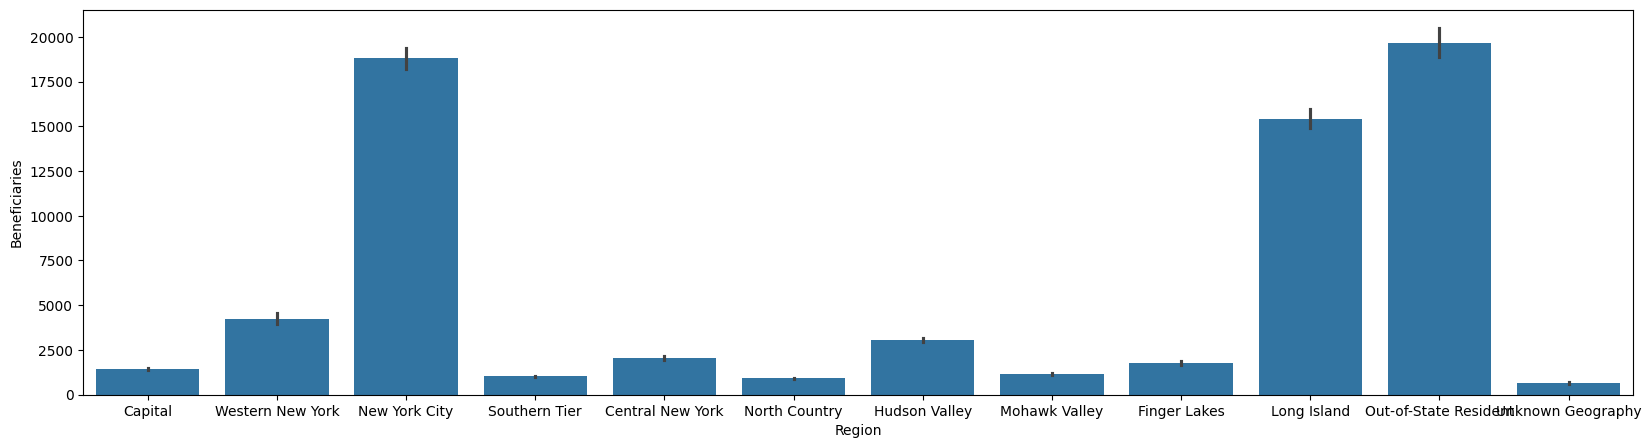

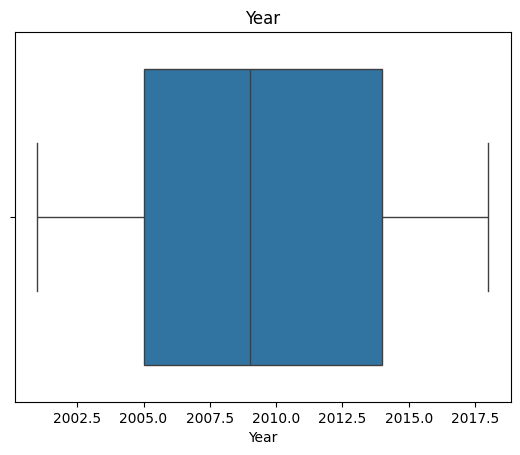

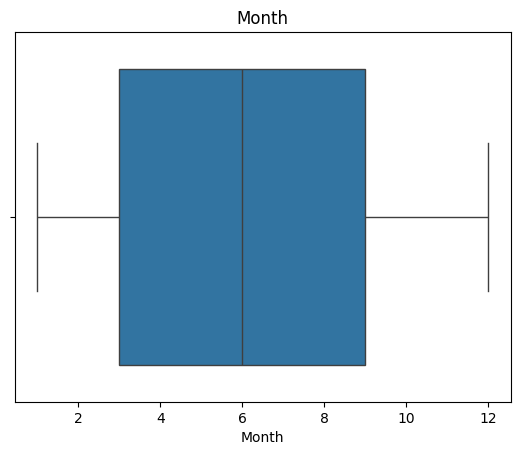

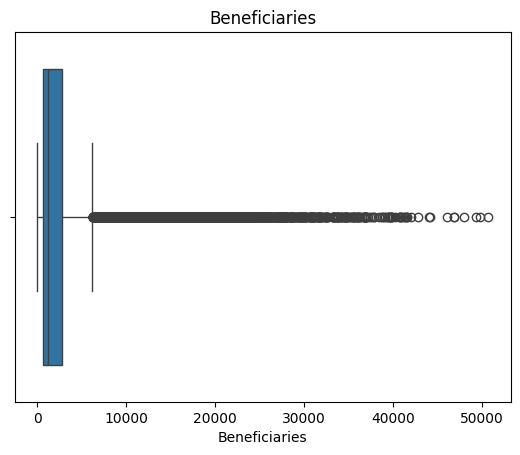

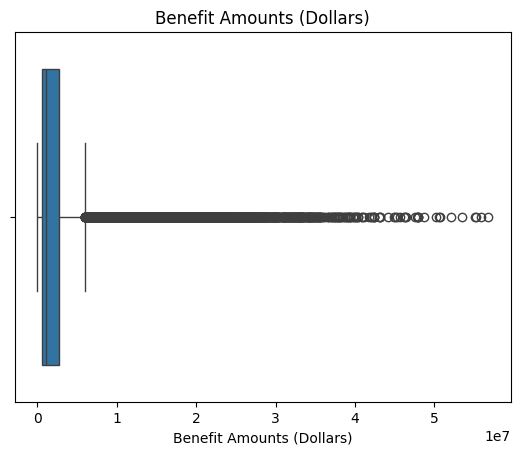

,Year,Month,Beneficiaries,Benefit Amounts (Dollars),Beneficiaries_diff
count,13760.000000,13760.000000,13760.000000,1.376000e+04,13759.000000
mean,2009.460465,6.474419,3858.335756,3.846968e+06,-0.094484
std,5.167803,3.439709,6557.550710,6.878640e+06,9431.460815
min,2001.000000,1.000000,0.000000,0.000000e+00,-50200.000000
25%,2005.000000,3.000000,600.000000,5.700000e+05,-1200.000000
50%,2009.000000,6.000000,1200.000000,1.110000e+06,0.000000
75%,2014.000000,9.000000,2800.000000,2.720000e+06,1500.000000
max,2018.000000,12.000000,50700.000000,5.681000e+07,49000.000000


In [3]:
#univariate analysis
fig = px.line(df, x='Year', y='Benefit Amounts (Dollars)')
fig.show()
fig = px.line(df, x='Year', y='Beneficiaries')
fig.show()

#Bivariate analysis
df1=df.query("County in ['Hamilton','Kings']")
fig = px.line(df1, x='Year', y='Beneficiaries', color='County')
fig.update_traces(textposition="bottom right")
fig.show()
fig=px.bar(df,x='Region',y='Beneficiaries',color='Region',text_auto=True)
fig.show()

plt.figure(figsize=(20,5))
sns.barplot(x=df.Region,y=df.Beneficiaries)
plt.show()

#Multivariate Analysis
for i in df.columns:
  if(df[i].dtype)=='int64':
    boxplot=sns.boxplot(x=df[i])
    plt.title(i)
    plt.show()
    df['Beneficiaries_diff']=df['Beneficiaries'].diff() #smoothing
#Decriptive Analysis
df.describe()


Training and testing creation

In [26]:
#train and test
df.dropna(inplace=True)
# Create a Datetime index
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-01')
df.set_index('Date', inplace=True)

train_size = int(len(df)*0.8)
train,test =df[:train_size],df[train_size:]

Model building

P-Value 1.1755411069411166e-28
P-Value 0.0


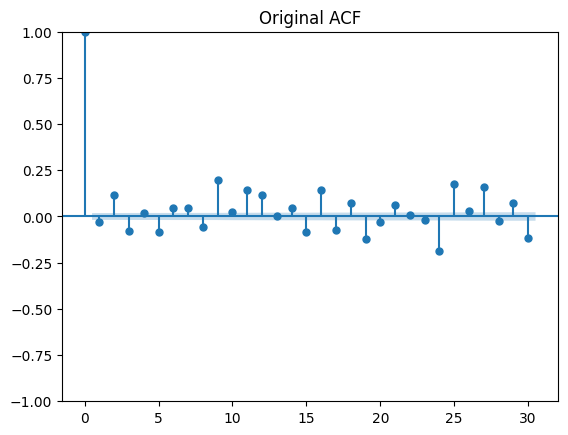

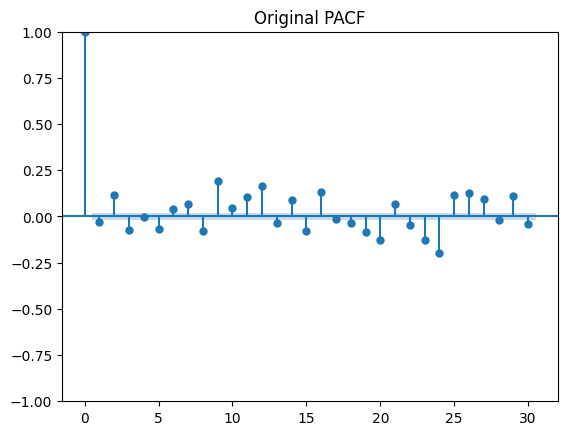

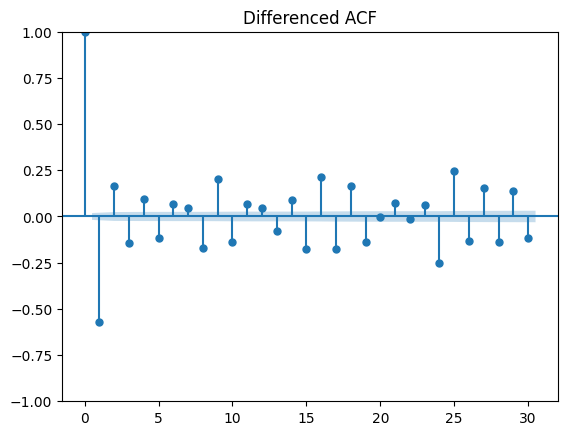

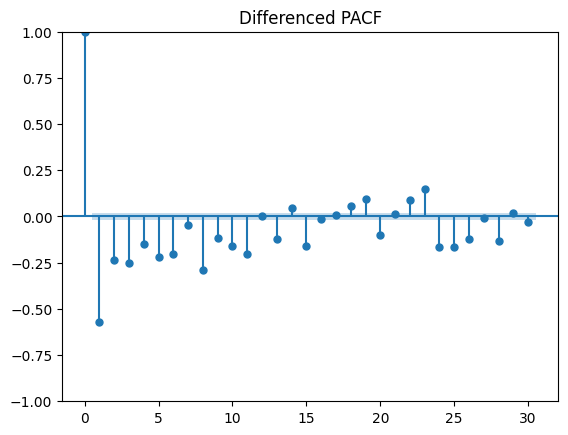

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency infor

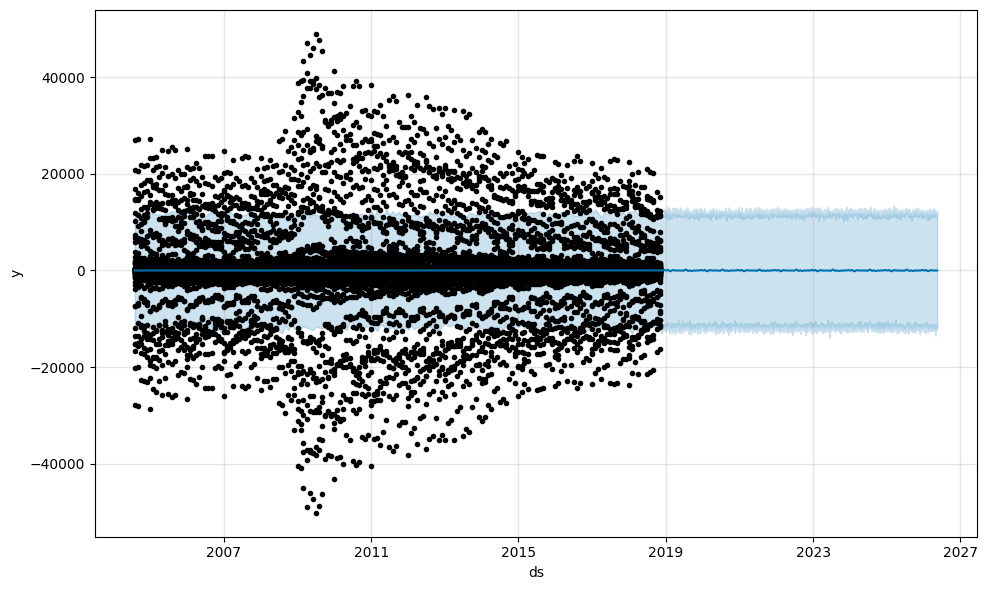

In [27]:
#Augmented Dickey-Fuller test

adf=adfuller(df['Beneficiaries'],autolag='AIC')
print("P-Value",adf[1])
adf=adfuller(train['Beneficiaries_diff'],autolag='AIC')
print("P-Value",adf[1])

#ACF and PACF
plot_acf(train['Beneficiaries'], lags=30, title='Original ACF')
plot_pacf(train['Beneficiaries'], lags=30, title='Original PACF')
plt.show()
plot_acf(train['Beneficiaries_diff'], lags=30, title='Differenced ACF')
plot_pacf(train['Beneficiaries_diff'], lags=30, title='Differenced PACF')
plt.show()

#ARIMA
#from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
#stepwise=auto_arima(df['Beneficiaries_diff'], trace=True, supress_warnings=True)
model = ARIMA(train['Beneficiaries_diff'], order=(5,0,0))
model_arima=model.fit()
model_arima.summary()

#SARIMA

model=SARIMAX(train['Beneficiaries_diff'],order=(5,0,0),seasonal_order=(0,1,2,3))
model_sarima=model.fit()
model_sarima.summary()

#Auto Regression

model_ar=AutoReg(train['Beneficiaries_diff'], lags=10).fit()
model_ar.summary()

#Prophet
model =VAR(train[['Beneficiaries_diff','Benefit Amounts (Dollars)']])
model_AR = model.fit(maxlags=10)


#Perfromace Testing
#Arima
prediction_arima =model_arima.predict(start=len(train),  #
                                    end=len(train)+len(test)-1,
                                    type='levels')
prediction_arima

#metrics for checking the model
mean_squared_error(test['Beneficiaries_diff'],prediction_arima)
mean_absolute_error(test['Beneficiaries_diff'],prediction_arima)
r2_score(test['Beneficiaries_diff'],prediction_arima)

#SARIMA
prediction_sarima=model_sarima.predict(start=len(train),
                               end=len(train)+ len(test)-1,
                               type='levels')
#metric check for SARIMA
mean_squared_error(test['Beneficiaries_diff'],prediction_sarima)
mean_absolute_error(test['Beneficiaries_diff'],prediction_sarima)

#building  AR model
predictions_ar=model_ar.predict(start=len(train),end=len(train)+len(test)-1)
#building VAR model
prediction_var = model_AR.forecast(train[['Beneficiaries_diff','Benefit Amounts (Dollars)']].values,steps=5)

#predicting prophet model
future = model_prophet.make_future_dataframe(periods=len(test))
forecast = model_.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].head()
model_AR.plot(forecast)#visualization of our forecast


Preformance check of the model

In [ ]:
actual_values= test['y'].values
predicted_values=forecast[-len(test):]['yhat'].values
mse = mean_squared_error(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)
r2 = r2_score(actual_values, predicted_values)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)